<a href="https://colab.research.google.com/github/Firojpaudel/GenAI-Chronicles/blob/main/GANs/Trying_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 
[![Run in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/kernels/welcome?src=https://github.com/Firojpaudel/GenAI-Chronicles/blob/main/GANs/Trying_with_numpy.ipynb)

## Trying to code GAN Using Numpy:
___

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#@ For Dataset
from torchvision import datasets, transforms

In [ ]:
##@ Defining the activation function

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
##@ The generator function

def generator(z, weights):
    return sigmoid(np.dot(z, weights['g_w']) + weights['g_b'])


In [ ]:
##@ The discriminator function

def descriminator (x, weights):
    return sigmoid(np.dot(x, weights['d_w']) + weights['d_b'])

$$Loss = -\mathbb{E}_{x\sim p_{real}}[log(D(x))]-\mathbb{E}_{z\sim p_{z}}[1- log(D(G(z)))] $$

In [ ]:
##@ Loss: We will use the binary cross entropy loss

def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))


The reason for adding `1e-8` to the formula as extra is we are trying to avoid the zero logarithm problem by adding a small constant

In [ ]:
##@ Now, time for loading the MNIST data

def load_mnist_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
    data = mnist.data.numpy().reshape(-1, 28*28)/255.0  # Flattening and normalizing to [0,1]
    labels = mnist.targets.numpy()
    return data, labels

So, this is the data that we importing from pytorch. Explaining what this code block is doing:

- `transforms.Compose()` is used to combine multiple transformation operations into a single pipeline.
- `transforms.ToTensor()` converts the PIL.Images to the tensors
- `transforms.Normalize()` is just normalizing the image tensor. It takes 2 arguements:
    - mean = 0.5
    - std = 0.5

$$ \text{Normalized_value} = \frac{value - mean}{std}$$

In [ ]:
##@ Visualizing the generated images

def plot_image(image, title= None):
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
##@ The Training Loop

def train_GAN(weights, real_data, epochs, lr, display_interval):
    batch_size = 64
    # 1. Training the Discriminator
    for epoch in range(epochs):
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_batch = real_data[idx]

        z= np.random.uniform(-1,1, size=(batch_size, 100))
        fake_batch = generator(z, weights)

        # Desc outputs
        real_output = descriminator(real_batch, weights)
        fake_output = descriminator(fake_batch, weights)

        # Desc Loss
        d_loss = binary_cross_entropy(np.ones(batch_size), real_output) + \
            binary_cross_entropy(np.zeros(batch_size), fake_output)

        # Now time for the back-prop in descriminator: calculating the gradients
        grad_d_w_real = np.dot(real_batch.T, (real_output -1)) / batch_size
        grad_d_w_fake = np.dot(fake_batch.T, fake_output) / batch_size
        grad_d_w = grad_d_w_real + grad_d_w_fake
        grad_d_b = np.mean((real_output -1) + fake_output, axis=0, keepdims=True)


        # Updating the descriminator weights
        weights['d_w'] -= lr * grad_d_w
        weights['d_b'] -= lr * grad_d_b

        # 2. Training the Generator
        z= np.random.uniform(-1,1, size=(batch_size, 100))
        fake_batch = generator(z, weights)
        fake_output = descriminator(fake_batch, weights)

        # Gen Loss
        g_loss = binary_cross_entropy(np.ones((batch_size, 1)), fake_output)

        # Now time for the back-prop in generator: calculating the gradients
        grad_g = np.dot(z.T, (fake_output -1) @ weights['d_w'].T) / batch_size
        grad_g_b = np.mean((fake_output -1), axis=0, keepdims=True) @ weights['d_w'].T


        # Updating the generator weights
        weights['g_w'] -= lr * grad_g
        weights['g_b'] -= lr * grad_g_b

        # Displaying the losses and generating the images
        if epoch % display_interval == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

            # Visualizing the generated image
            generated_image = fake_batch[0] #Taking the first image
            plot_image(generated_image)

Why are we using `np.ones` and `np.zeros` and summing them?

We are just calulating the `Real_data Loss`, `Fake_data Loss` and simply summing them.

Here, we are gathering all the ones i.e all the real datas and calculating the loss comparing with the real_output
and opposite goes for `np.zeros`.

$$  \frac{\partial L}{\partial W_{hidden}} = \frac{1}{batch\_size} \cdot \eta \cdot real\_batch^{T} \cdot (real\_output -1) $$

The formula `(real_output -1) + fake_data` comes from the derivative of the dicriminators loss wrt its output.

> Real_output =`D(x)` \
> Fake_output = `D(G(z))`

For Real, the gradient of $\log D(x)$ with respect to $D(x)$ is $\frac{1}{D(x)}$ and if we apply chain rule we get `real_output-1`

For fake, the gradient of $\log(1- D(G(z)))$ with repect to fake_output $D(G(z))$ is $\frac{-1}{1- D(G(z))}$ which leads to fake_output. Hence, we have `(real_output -1) + fake_data`.



Epoch: 0, D Loss: 13.989076249374122, G Loss: 8.904794641610247


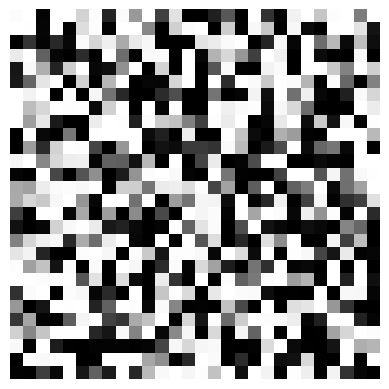

Epoch: 5000, D Loss: 0.5061590928101195, G Loss: 4.349018508914373


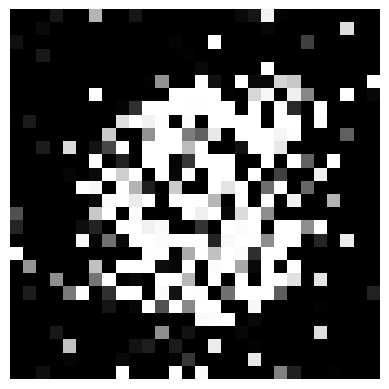

Epoch: 10000, D Loss: 0.7894894397957706, G Loss: 2.937126201505151


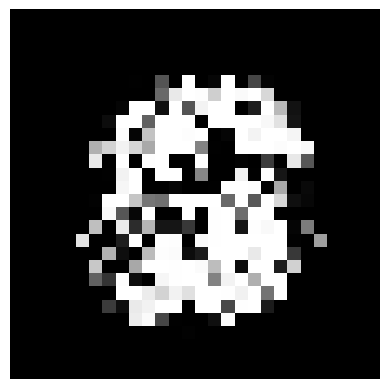

In [ ]:
##@ Main Function

if __name__ == "__main__":

    #@ Load Data
    real_data, _ = load_mnist_data()

    #@ Initialize the weights
    weights = {
        'g_w': np.random.randn(100, 784),
        'g_b': np.zeros((1, 784)),
        'd_w': np.random.randn(784, 1),
        'd_b': np.zeros((1, 1))
    }

    train_GAN(weights, real_data, epochs=10001, lr= 0.005, display_interval=5000)


It does look like its trying to generate but not sure where it went wrong...

So, will try this in pyTorch Instead